In [1]:
#!pip install wordcloud
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [2]:
data=pd.read_csv("ds_salaries.csv")

In [3]:
print(data.shape)

(3755, 11)


In [4]:
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [5]:
data.nunique()

work_year                4
experience_level         4
employment_type          4
job_title               93
salary                 815
salary_currency         20
salary_in_usd         1035
employee_residence      78
remote_ratio             3
company_location        72
company_size             3
dtype: int64

In [6]:
data.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [7]:
data.duplicated().sum()

1171

In [8]:
data = data.drop_duplicates()

In [9]:
data.duplicated().sum()

0

In [10]:
data.dtypes

work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object

In [11]:
numerical_columns=data.select_dtypes(include=['int64']).columns
categorical_columns=data.select_dtypes(include=['object']).columns

In [12]:
numerical_columns

Index(['work_year', 'salary', 'salary_in_usd', 'remote_ratio'], dtype='object')

In [13]:
categorical_columns

Index(['experience_level', 'employment_type', 'job_title', 'salary_currency',
       'employee_residence', 'company_location', 'company_size'],
      dtype='object')

In [14]:
data.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,2584.000000,2.584000e+03,2584.000000,2584.000000
mean,2022.301084,2.103653e+05,133409.280186,50.483746
std,0.749179,8.080375e+05,67136.837329,48.163707
min,2020.000000,6.000000e+03,5132.000000,0.000000
25%,2022.000000,9.000000e+04,84975.000000,0.000000
50%,2022.000000,1.346300e+05,130000.000000,50.000000
75%,2023.000000,1.825625e+05,175000.000000,100.000000
max,2023.000000,3.040000e+07,450000.000000,100.000000


In [15]:
iso_forest=IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(data[numerical_columns])
outlier_count = (outliers == -1).sum()
total_count = len(outliers)
outlier_percentage = (outlier_count / total_count) * 100
print(f"Percentage of numerical outliers: {outlier_percentage:.2f}%")

Percentage of numerical outliers: 5.03%


C:\Users\nipun\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [16]:
cat_outliers = {}
cat_outlier_count = 0

for col in categorical_columns:
    value_counts = data[col].value_counts()
    rare_categories = value_counts[value_counts < 0.05 * len(data)]
    cat_outliers[col] = rare_categories.index.tolist()
    cat_outlier_count += data[col].isin(rare_categories.index).sum()

total_count = len(data)

categorical_outlier_percentage = (cat_outlier_count / total_count) * 100

print(f"Categorical outliers count: {cat_outlier_count}")
print(f"Categorical outliers percentage: {categorical_outlier_percentage:.2f}%")

Categorical outliers count: 2153
Categorical outliers percentage: 83.32%


In [17]:
data['salary_category'] = pd.cut(
    data['salary_in_usd'],
    bins=[0, 100000, 200000, float('inf')],
    labels=['salary<100,000 USD', '100,000≤salary<200,000 USD', 'salary≥200,000 USD']
)

data[['salary_in_usd', 'salary_category']].head()


,salary_in_usd,salary_category
0,85847,"salary<100,000 USD"
1,30000,"salary<100,000 USD"
2,25500,"salary<100,000 USD"
3,175000,"100,000≤salary<200,000 USD"
4,120000,"100,000≤salary<200,000 USD"


In [18]:
def ratio_class(ratio):
    if ratio == 100:
        return 'Remote'
    elif ratio == 0:
        return 'In-Person'
    else:
        return 'Hybrid'

In [19]:
data['ratio_class'] = data['remote_ratio'].apply(ratio_class)
data['ratio_class'].value_counts()

ratio_class
Remote       1211
In-Person    1186
Hybrid        187
Name: count, dtype: int64

In [20]:
# Experience level
data['experience_level'] = data['experience_level'].replace(
    {'EN': 'Entry-Level',
     'MI': 'Mid-Level',
     'SE': 'Senior',
     'EX': 'Executive'} 
)

# Company Size
data['company_size'] = data['company_size'].replace(
    {'S': 'Small',
     'M': 'Medium',
     'L': 'Large'}
)

In [21]:
def assign_broader_category(job_title):
    data_engineering = ["Data Engineer", "Data Analyst", "Analytics Engineer", "BI Data Analyst", "Business Data Analyst", "BI Developer", "BI Analyst", "Business Intelligence Engineer", "BI Data Engineer", "Power BI Developer"]
    data_scientist = ["Data Scientist", "Applied Scientist", "Research Scientist", "3D Computer Vision Researcher", "Deep Learning Researcher", "AI/Computer Vision Engineer"]
    machine_learning = ["Machine Learning Engineer", "ML Engineer", "Lead Machine Learning Engineer", "Principal Machine Learning Engineer"]
    data_architecture = ["Data Architect", "Big Data Architect", "Cloud Data Architect", "Principal Data Architect"]
    management = ["Data Science Manager", "Director of Data Science", "Head of Data Science", "Data Scientist Lead", "Head of Machine Learning", "Manager Data Management", "Data Analytics Manager"]
    
    if job_title in data_engineering:
        return "Data Engineering"
    elif job_title in data_scientist:
        return "Data Science"
    elif job_title in machine_learning:
        return "Machine Learning"
    elif job_title in data_architecture:
        return "Data Architecture"
    elif job_title in management:
        return "Management"
    else:
        return "Other"

data['job_category'] = data['job_title'].apply(assign_broader_category)


In [22]:
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,salary_category,ratio_class,job_category
0,2023,Senior,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,Large,"salary<100,000 USD",Remote,Other
1,2023,Mid-Level,CT,ML Engineer,30000,USD,30000,US,100,US,Small,"salary<100,000 USD",Remote,Machine Learning
2,2023,Mid-Level,CT,ML Engineer,25500,USD,25500,US,100,US,Small,"salary<100,000 USD",Remote,Machine Learning
3,2023,Senior,FT,Data Scientist,175000,USD,175000,CA,100,CA,Medium,"100,000≤salary<200,000 USD",Remote,Data Science
4,2023,Senior,FT,Data Scientist,120000,USD,120000,CA,100,CA,Medium,"100,000≤salary<200,000 USD",Remote,Data Science


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2584 entries, 0 to 3754
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   work_year           2584 non-null   int64   
 1   experience_level    2584 non-null   object  
 2   employment_type     2584 non-null   object  
 3   job_title           2584 non-null   object  
 4   salary              2584 non-null   int64   
 5   salary_currency     2584 non-null   object  
 6   salary_in_usd       2584 non-null   int64   
 7   employee_residence  2584 non-null   object  
 8   remote_ratio        2584 non-null   int64   
 9   company_location    2584 non-null   object  
 10  company_size        2584 non-null   object  
 11  salary_category     2584 non-null   category
 12  ratio_class         2584 non-null   object  
 13  job_category        2584 non-null   object  
dtypes: category(1), int64(4), object(9)
memory usage: 285.3+ KB


## Model Fiiting

In [24]:
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,salary_category,ratio_class,job_category
0,2023,Senior,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,Large,"salary<100,000 USD",Remote,Other
1,2023,Mid-Level,CT,ML Engineer,30000,USD,30000,US,100,US,Small,"salary<100,000 USD",Remote,Machine Learning
2,2023,Mid-Level,CT,ML Engineer,25500,USD,25500,US,100,US,Small,"salary<100,000 USD",Remote,Machine Learning
3,2023,Senior,FT,Data Scientist,175000,USD,175000,CA,100,CA,Medium,"100,000≤salary<200,000 USD",Remote,Data Science
4,2023,Senior,FT,Data Scientist,120000,USD,120000,CA,100,CA,Medium,"100,000≤salary<200,000 USD",Remote,Data Science


In [25]:
data.drop(['salary_in_usd','job_title','remote_ratio','salary'],axis=1,inplace= True)
data.head()

,work_year,experience_level,employment_type,salary_currency,employee_residence,company_location,company_size,salary_category,ratio_class,job_category
0,2023,Senior,FT,EUR,ES,ES,Large,"salary<100,000 USD",Remote,Other
1,2023,Mid-Level,CT,USD,US,US,Small,"salary<100,000 USD",Remote,Machine Learning
2,2023,Mid-Level,CT,USD,US,US,Small,"salary<100,000 USD",Remote,Machine Learning
3,2023,Senior,FT,USD,CA,CA,Medium,"100,000≤salary<200,000 USD",Remote,Data Science
4,2023,Senior,FT,USD,CA,CA,Medium,"100,000≤salary<200,000 USD",Remote,Data Science


In [26]:
from sklearn.preprocessing import OrdinalEncoder

# Initialize the OrdinalEncoder
ordinal_encoder = OrdinalEncoder(categories=[['salary<100,000 USD', '100,000≤salary<200,000 USD', 'salary≥200,000 USD']])

# Fit and transform the salary_category column
data['salary_category_numeric'] = ordinal_encoder.fit_transform(data[['salary_category']]).astype(int) + 1

# Display the result
data[['salary_category', 'salary_category_numeric']].head()


,salary_category,salary_category_numeric
0,"salary<100,000 USD",1
1,"salary<100,000 USD",1
2,"salary<100,000 USD",1
3,"100,000≤salary<200,000 USD",2
4,"100,000≤salary<200,000 USD",2


In [27]:
data.drop(['salary_category'],axis=1,inplace= True)
data.head()

,work_year,experience_level,employment_type,salary_currency,employee_residence,company_location,company_size,ratio_class,job_category,salary_category_numeric
0,2023,Senior,FT,EUR,ES,ES,Large,Remote,Other,1
1,2023,Mid-Level,CT,USD,US,US,Small,Remote,Machine Learning,1
2,2023,Mid-Level,CT,USD,US,US,Small,Remote,Machine Learning,1
3,2023,Senior,FT,USD,CA,CA,Medium,Remote,Data Science,2
4,2023,Senior,FT,USD,CA,CA,Medium,Remote,Data Science,2


In [28]:
data = pd.get_dummies(data,columns=['experience_level','salary_currency','employment_type', 'employee_residence', 'company_location', 'company_size','job_category','ratio_class'],dtype=int)

In [29]:
data.head()

,work_year,salary_category_numeric,experience_level_Entry-Level,experience_level_Executive,experience_level_Mid-Level,experience_level_Senior,salary_currency_AUD,salary_currency_BRL,salary_currency_CAD,salary_currency_CHF,...,company_size_Small,job_category_Data Architecture,job_category_Data Engineering,job_category_Data Science,job_category_Machine Learning,job_category_Management,job_category_Other,ratio_class_Hybrid,ratio_class_In-Person,ratio_class_Remote
0,2023,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,2023,1,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
2,2023,1,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
3,2023,2,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,2023,2,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2584 entries, 0 to 3754
Columns: 192 entries, work_year to ratio_class_Remote
dtypes: int32(191), int64(1)
memory usage: 1.9 MB


In [31]:
X = data.drop('salary_category_numeric',axis=1)
y = data['salary_category_numeric']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)

In [32]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import mord as m
import warnings
warnings.simplefilter(action='ignore')

# Define models with parameter grids for hyperparameter tuning
model_params = {
    'Ordinal Logistic Regression': {
        'model': m.LogisticAT(),  # Using Mord's LogisticAT for ordinal regression
        'params': {
            'alpha': [0.1, 0.5, 1.0]  # Regularization parameter
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, 15]
        }
    },
    'GaussianNB': {
        'model': GaussianNB(),
        'params': {}
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 1]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.5],
            'max_depth': [3, 5, 7]
        }
    }
   
}

# Loop through each model and perform hyperparameter tuning with GridSearchCV
for name, model_dict in model_params.items():
    print(f"Training {name} with hyperparameter tuning...")
    grid_search = GridSearchCV(model_dict['model'], model_dict['params'], cv=5, scoring='accuracy')
    
   
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    
    # Training predictions and metrics
    train_pred = best_model.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    train_err = 1 - train_acc
    train_f1 = f1_score(y_train, train_pred, average='weighted')
    train_cm = confusion_matrix(y_train, train_pred)
    train_sensitivity = train_cm[1, 1] / (train_cm[1, 1] + train_cm[1, 0]) if (train_cm[1, 1] + train_cm[1, 0]) != 0 else 0
    train_specificity = train_cm[0, 0] / (train_cm[0, 0] + train_cm[0, 1]) if (train_cm[0, 0] + train_cm[0, 1]) != 0 else 0
    
    # Test predictions and metrics
    test_pred = best_model.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    test_err = 1 - test_acc
    test_f1 = f1_score(y_test, test_pred, average='weighted')
    test_cm = confusion_matrix(y_test, test_pred)
    test_sensitivity = test_cm[1, 1] / (test_cm[1, 1] + test_cm[1, 0]) if (test_cm[1, 1] + test_cm[1, 0]) != 0 else 0
    test_specificity = test_cm[0, 0] / (test_cm[0, 0] + test_cm[0, 1]) if (test_cm[0, 0] + test_cm[0, 1]) != 0 else 0
    
    # Print results
    print(name)
    print('=' * len(name))
    print(f'Best Parameters: {grid_search.best_params_}')
    print(f'Training Accuracy: {train_acc:.4f}')
    print(f'Training Error Rate: {train_err:.4f}')
    print(f'Training F1 Score: {train_f1:.4f}')
    print(f'Training Confusion Matrix:\n{train_cm}')
    print(f'Training Sensitivity: {train_sensitivity:.4f}')
    print(f'Training Specificity: {train_specificity:.4f}')
    print('\n')
    print(f'Test Accuracy: {test_acc:.4f}')
    print(f'Test Error Rate: {test_err:.4f}')
    print(f'Test F1 Score: {test_f1:.4f}')
    print(f'Test Confusion Matrix:\n{test_cm}')
    print(f'Test Sensitivity: {test_sensitivity:.4f}')
    print(f'Test Specificity: {test_specificity:.4f}')
    print('\n' + '=' * 30 + '\n')


Training Ordinal Logistic Regression with hyperparameter tuning...
Ordinal Logistic Regression
Best Parameters: {'alpha': 1.0}
Training Accuracy: 0.7092
Training Error Rate: 0.2908
Training F1 Score: 0.6620
Training Confusion Matrix:
[[456 231   1]
 [ 70 999  12]
 [  2 285  11]]
Training Sensitivity: 0.9345
Training Specificity: 0.6638


Test Accuracy: 0.6712
Test Error Rate: 0.3288
Test F1 Score: 0.6188
Test Confusion Matrix:
[[101  78   0]
 [ 17 243   0]
 [  2  73   3]]
Test Sensitivity: 0.9346
Test Specificity: 0.5642


Training Random Forest with hyperparameter tuning...
Random Forest
Best Parameters: {'max_depth': 10, 'n_estimators': 200}
Training Accuracy: 0.7257
Training Error Rate: 0.2743
Training F1 Score: 0.6728
Training Confusion Matrix:
[[ 475  213    0]
 [  62 1019    0]
 [   3  289    6]]
Training Sensitivity: 0.9426
Training Specificity: 0.6904


Test Accuracy: 0.6712
Test Error Rate: 0.3288
Test F1 Score: 0.6125
Test Confusion Matrix:
[[105  74   0]
 [ 18 242   0]
 [  2

In [33]:
# Remap target labels
y_train_mapped = y_train - 1
y_test_mapped = y_test - 1

# Define XGBoost model with parameter grid for hyperparameter tuning
xgb_model_params = {
    'model': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'params': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.5],
        'max_depth': [3, 5, 7]
    }
}

# Perform hyperparameter tuning with GridSearchCV
print("Training XGBoost with hyperparameter tuning...")
grid_search = GridSearchCV(xgb_model_params['model'], xgb_model_params['params'], cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train_mapped)

best_model = grid_search.best_estimator_

# Training predictions and metrics
train_pred = best_model.predict(X_train)
train_acc = accuracy_score(y_train_mapped, train_pred)
train_err = 1 - train_acc
train_f1 = f1_score(y_train_mapped, train_pred, average='weighted')
train_cm = confusion_matrix(y_train_mapped, train_pred)
train_sensitivity = train_cm[1, 1] / (train_cm[1, 1] + train_cm[1, 0]) if (train_cm[1, 1] + train_cm[1, 0]) != 0 else 0
train_specificity = train_cm[0, 0] / (train_cm[0, 0] + train_cm[0, 1]) if (train_cm[0, 0] + train_cm[0, 1]) != 0 else 0

# Test predictions and metrics
test_pred = best_model.predict(X_test)
test_acc = accuracy_score(y_test_mapped, test_pred)
test_err = 1 - test_acc
test_f1 = f1_score(y_test_mapped, test_pred, average='weighted')
test_cm = confusion_matrix(y_test_mapped, test_pred)
test_sensitivity = test_cm[1, 1] / (test_cm[1, 1] + test_cm[1, 0]) if (test_cm[1, 1] + test_cm[1, 0]) != 0 else 0
test_specificity = test_cm[0, 0] / (test_cm[0, 0] + test_cm[0, 1]) if (test_cm[0, 0] + test_cm[0, 1]) != 0 else 0

# Print results
print("XGBoost")
print("=" * len("XGBoost"))
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Training Accuracy: {train_acc:.4f}')
print(f'Training Error Rate: {train_err:.4f}')
print(f'Training F1 Score: {train_f1:.4f}')
print(f'Training Confusion Matrix:\n{train_cm}')
print(f'Training Sensitivity: {train_sensitivity:.4f}')
print(f'Training Specificity: {train_specificity:.4f}')
print('\n')
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Error Rate: {test_err:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')
print(f'Test Confusion Matrix:\n{test_cm}')
print(f'Test Sensitivity: {test_sensitivity:.4f}')
print(f'Test Specificity: {test_specificity:.4f}')
print('\n' + '=' * 30 + '\n')


Training XGBoost with hyperparameter tuning...
XGBoost
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Training Accuracy: 0.7276
Training Error Rate: 0.2724
Training F1 Score: 0.6863
Training Confusion Matrix:
[[ 477  211    0]
 [  69 1003    9]
 [   6  268   24]]
Training Sensitivity: 0.9356
Training Specificity: 0.6933


Test Accuracy: 0.6731
Test Error Rate: 0.3269
Test F1 Score: 0.6299
Test Confusion Matrix:
[[108  69   2]
 [ 18 236   6]
 [  1  73   4]]
Test Sensitivity: 0.9291
Test Specificity: 0.6102




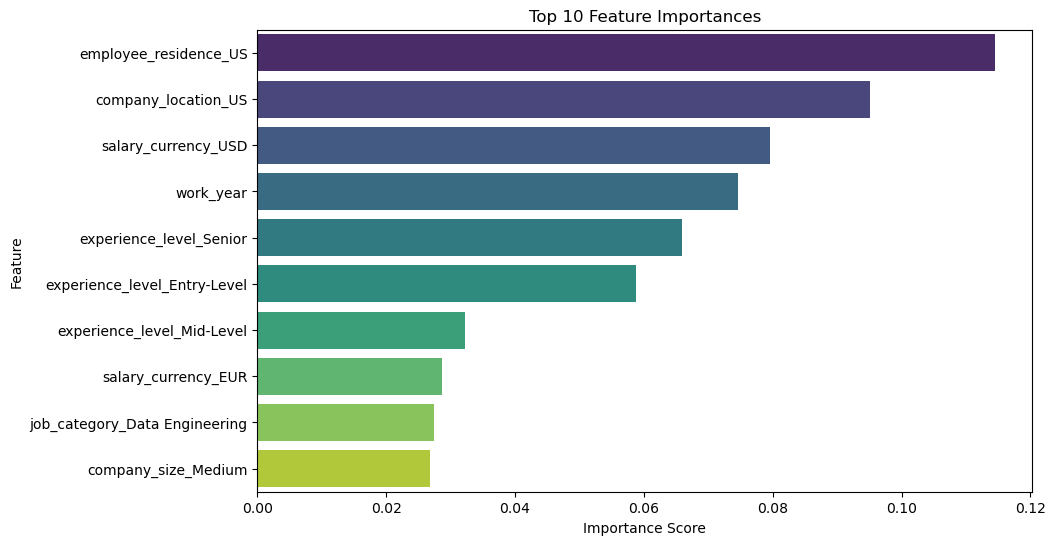

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

# Train the Random Forest model on the training data with the best parameters
random_forest = RandomForestClassifier(n_estimators=50, max_depth=15, random_state=42)
random_forest.fit(X_train, y_train)

# Get feature importances
feature_importances = random_forest.feature_importances_
features = X_train.columns  

# Create a DataFrame to store feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top 10 features
top_features = feature_importance_df.head(10)

# Plot feature importance using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_features, palette="viridis")
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()
